In [1]:
import os
import torch

device = torch.device('cpu')
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from botorch.test_functions import Hartmann


neg_hartmann6 = Hartmann(negate=True)


def outcome_constraint(X):
    """L1 constraint; feasible if less than or equal to zero."""
    return X.sum(dim=-1) - 3

def weighted_obj(X):
    """Feasibility weighted objective; zero if not feasible."""
    return neg_hartmann6(X) * (outcome_constraint(X) <= 0).type_as(X)



ModuleNotFoundError: No module named 'botorch'

In [38]:
from botorch.models import FixedNoiseGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
NOISE_SE = 0.5
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)
def generate_initial_data(n=10):
    train_x = torch.rand(10, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    train_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    best_observed_value = weighted_obj(train_x).max().item()
    return train_x, train_obj, train_con, best_observed_value
    
def initialize_model(train_x, train_obj, train_con, state_dict=None):
    model_obj = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj)).to(train_x)
    model_con = FixedNoiseGP(train_x, train_con, train_yvar.expand_as(train_con)).to(train_x)

    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    return mll, model


In [39]:
from botorch.acquisition.objective import ConstrainedMCObjective
def obj_callable(Z):
    return Z[...,0]
def constraint_callable(Z):
    return Z[...,1]

constrained_obj = ConstrainedMCObjective(objective=obj_callable, constraints=[constraint_callable],)

In [40]:
from botorch.optim import optimize_acqf
bounds = torch.tensor([[0.0]*6, [1.0]*6],device=device,dtype=dtype)

In [43]:
# he function optimize_acqf optimizes the 𝑞 points jointly. 
# A simple initialization heuristic is used to select the 10 restart initial locations from a set of 50 random points.

BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values 
    new_x = candidates.detach()
    exact_obj = neg_hartmann6(new_x).unsqueeze(-1)  # add output dimension
    exact_con = outcome_constraint(new_x).unsqueeze(-1)  # add output dimension
    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_con = exact_con + NOISE_SE * torch.randn_like(exact_con)
    return new_x, new_obj, new_con


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 6)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))       
    return best_random

In [44]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning

import time
import warnings


warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32

verbose = False

best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []


# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_nei, best_random = [], [], []
    
    # call helper functions to generate initial training data and initialize model
    train_x_ei, train_obj_ei, train_con_ei, best_observed_value_ei = generate_initial_data(n=10)
    mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei, train_con_ei)
    
    train_x_nei, train_obj_nei, train_con_nei = train_x_ei, train_obj_ei, train_con_ei
    best_observed_value_nei = best_observed_value_ei
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei, train_con_nei)
    
    best_observed_ei.append(best_observed_value_ei)
    best_observed_nei.append(best_observed_value_nei)
    best_random.append(best_observed_value_ei)
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.monotonic()
        
        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_nei)
        
        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
        
        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model=model_ei, 
            best_f=(train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max(),
            sampler=qmc_sampler, 
            objective=constrained_obj,
        )
        
        qNEI = qNoisyExpectedImprovement(
            model=model_nei, 
            X_baseline=train_x_nei,
            sampler=qmc_sampler, 
            objective=constrained_obj,
        )
        
        # optimize and get new observation
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qEI)
        new_x_nei, new_obj_nei, new_con_nei = optimize_acqf_and_get_observation(qNEI)
                
        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
        train_con_ei = torch.cat([train_con_ei, new_con_ei])

        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_con_nei = torch.cat([train_con_nei, new_con_nei])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = weighted_obj(train_x_ei).max().item()
        best_value_nei = weighted_obj(train_x_nei).max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_nei.append(best_value_nei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei, 
            train_obj_ei, 
            train_con_ei, 
            model_ei.state_dict(),
        )
        mll_nei, model_nei = initialize_model(
            train_x_nei, 
            train_obj_nei, 
            train_con_nei, 
            model_nei.state_dict(),
        )
        
        t1 = time.monotonic()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_nei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
   
    best_observed_all_ei.append(best_observed_ei)
    best_observed_all_nei.append(best_observed_nei)
    best_random_all.append(best_random)



Trial  1 of 3 

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.
Trial  2 of 3 

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.
Trial  3 of 3 

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


.

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


..

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


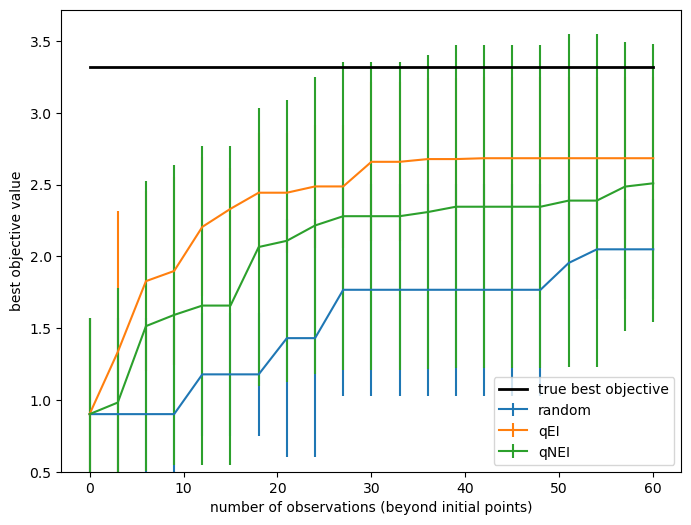

In [46]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_ei)
y_nei = np.asarray(best_observed_all_nei)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_nei.mean(axis=0), yerr=ci(y_nei), label="qNEI", linewidth=1.5)
plt.plot([0, N_BATCH * BATCH_SIZE], [GLOBAL_MAXIMUM] * 2, 'k', label="true best objective", linewidth=2)
ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
ax.legend(loc="lower right")

In [ ]:
from utils.seq_utils import *
import pandas as pd
import os
import math
import torch


import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel
from torch.utils.data import Dataset, DataLoader
import gpytorch

class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

protein_alphabet = "ACDEFGHIKLMNPQRSTVWY" 

df = pd.read_csv('unify-length/1ADQ_A.csv')
cdr3, energy = df['CDR3'], df['Energy']

  
alphabet = protein_alphabet
one_hot_cdr3 = []
for sequence in cdr3:
    one_hot = sequence_to_one_hot(sequence, alphabet)
    one_hot_cdr3.append(one_hot)

energy = torch.tensor(energy.values).unsqueeze(1)
one_hot_cdr3 = torch.stack(one_hot_cdr3).to('cpu')
train_dataset = ProteinDataset(one_hot_cdr3, energy)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

likelihood = GaussianLikelihood()
model=GPModel(train_x=one_hot_cdr3, train_y=energy, likelihood=likelihood)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# Train the model
model.train()
likelihood.train()
training_iter = 10

for i in range(training_iter):
    epoch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(one_hot_cdr3)
        
        loss = -mll(output, energy)
        loss_mean = loss.mean()
        loss_mean.backward()
        
        optimizer.step()
        
        print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            i, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss_mean.item()))
            
    print('Epoch: {}\tAverage Loss: {:.6f}'.format(i, epoch_loss / len(train_loader)))



In [1]:
from utils.seq_utils import *
import pandas as pd
import os
import math
import torch
import torch.nn as nn

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel
from torch.utils.data import Dataset, DataLoader
from botorch.models.gpytorch import GPyTorchModel

/home/czong/miniconda3/envs/pex/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GPCNN(ExactGP,GPyTorchModel):
    _num_outputs = 1
    def __init__(self, num_input_channels,train_X,train_Y, num_filters=32, hidden_dim=128, kernel_size=5):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.conv_1 = nn.Conv1d(num_input_channels, num_filters, kernel_size, padding="valid")
        self.conv_2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding="same")
        self.conv_3 = nn.Conv1d(num_filters, num_filters, kernel_size, padding="same")
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dense_1 = nn.Linear(num_filters, hidden_dim)
        self.dense_2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout_1 = nn.Dropout(0.25)
        self.dense_3 = nn.Linear(hidden_dim, 1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        # Input:  [batch_size, num_input_channels, sequence_length]
        # Output: [batch_size, 1]

        x = torch.relu(self.conv_1(x))
        x = torch.relu(self.conv_2(x))
        x = torch.relu(self.conv_3(x))
        x = torch.squeeze(self.global_max_pool(x), dim=-1)
        x = torch.relu(self.dense_1(x))
        x = torch.relu(self.dense_2(x))
        x = self.dropout_1(x)
        x = self.dense_3(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
    

In [3]:
def sequence_to_one_hot(sequence, alphabet):
    # Input:  - sequence: [sequence_length]
    #         - alphabet: [alphabet_size]
    # Output: - one_hot:  [sequence_length, alphabet_size]
    alphabet_dict = {x: idx for idx, x in enumerate(alphabet)}
    one_hot = F.one_hot(
        torch.tensor([alphabet_dict[x] for x in sequence]).long(), num_classes=len(alphabet)
    )
    return one_hot

def one_hot_to_sequence(one_hot, alphabet=="ACDEFGHIKLMNPQRSTVWY"):
    # Input:  - one_hot:  [sequence_length, alphabet_size]
    #         - alphabet: [alphabet_size]
    # Output: - sequence: [sequence_length]
    _, max_indices = torch.max(one_hot, dim=-1)
    alphabet_dict = {idx: x for idx, x in enumerate(alphabet)}
    sequence = [alphabet_dict[idx.item()] for idx in max_indices]
    return sequence

In [4]:
protein_alphabet = "ACDEFGHIKLMNPQRSTVWY" 

df = pd.read_csv('unify-length/1ADQ_A.csv')
cdr3, energy = df['CDR3'], df['Energy']

  
alphabet = protein_alphabet
one_hot_cdr3 = []
for sequence in cdr3:
    one_hot = sequence_to_one_hot(sequence, alphabet)
    one_hot_cdr3.append(one_hot)

energy = torch.tensor(energy.values).unsqueeze(1) # train_Y
one_hot_cdr3 = torch.stack(one_hot_cdr3).to('cpu') #train_X

In [8]:
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
model = GPCNN(num_input_channels=len(protein_alphabet), train_X=one_hot_cdr3, train_Y=energy)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

RuntimeError: Given groups=1, weight of size [32, 20, 5], expected input[104541, 17, 20] to have 20 channels, but got 17 channels instead

'0x1'

7618240